窗函數<br/>
https://zhuanlan.zhihu.com/p/24318554#:~:targetText=%E7%9B%B8%E5%AF%B9%E8%80%8C%E8%A8%80%EF%BC%8C%E5%A6%82%E6%9E%9C%E6%97%81,%E5%88%86%E8%BE%A8%E8%83%BD%E5%8A%9B%E4%B9%9F%E4%B8%8D%E4%B8%80%E6%A0%B7%E3%80%82

訊號處理<br/>
https://zhuanlan.zhihu.com/p/69244471

R-PCA<br/>
https://www.itread01.com/content/1541479143.html

梅爾頻率倒譜系數（MFCC）<br/>
https://www.itread01.com/content/1548626964.html

In [5]:
#!pip install soundfile

# Import Data

In [2]:
wav_file=".\\forDemo\\example_voice\\6_new.wav"
import soundfile as sf
data, sampling_rate = sf.read(wav_file)
fs=sampling_rate

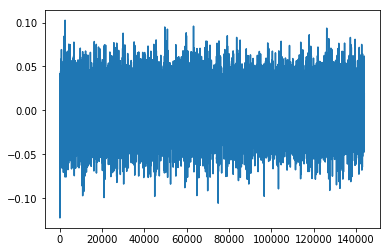

48000


In [5]:
import pylab as plt
plt.plot(data)
plt.show()
print(sampling_rate)

In [4]:
#增強訊號
from scipy import signal
b,a = signal.butter(1,1-0.97,'high')
data = signal.filtfilt(b,a,data)

In [78]:
import numpy as np
#normalize
max_sample = np.max(data)
min_sample = np.min(data)
scale = 2 * 0.925 / (max_sample-min_sample)
data = [sample * scale for sample in data]

In [79]:
def enframe(wave_data, nw, inc, winfunc):
    '''将音频信号转化为帧。
    参数含义：
    wave_data:原始音频型号
    nw:每一帧的长度(这里指采样点的长度，即采样频率乘以时间间隔)
    inc:相邻帧的间隔（同上定义）
    '''
    wlen=len(wave_data) #信号总长度
    if wlen<=nw: #若信号长度小于一个帧的长度，则帧数定义为1
        nf=1
    else: #否则，计算帧的总长度
        nf=int(np.ceil((1.0*wlen-nw+inc)/inc))
    pad_length=int((nf-1)*inc+nw) #所有帧加起来总的铺平后的长度
    zeros=np.zeros((pad_length-wlen,)) #不够的长度使用0填补，类似于FFT中的扩充数组操作
    pad_signal=np.concatenate((wave_data,zeros)) #填补后的信号记为pad_signal
    indices=np.tile(np.arange(0,nw),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(nw,1)).T  #相当于对所有帧的时间点进行抽取，得到nf*nw长度的矩阵
    indices=np.array(indices,dtype=np.int32) #将indices转化为矩阵
    frames=pad_signal[indices] #得到帧信号
    win=np.tile(winfunc,(nf,1))  #window窗函数，这里默认取1
    return frames*win   #返回帧信号矩阵


from scipy import signal
#分帧、加窗 
frame_length=32768
frame_shift = round(float(frame_length) * (1 / 4))
print(frame_shift)
winfunc = signal.hamming(frame_length) 
X=enframe(data, frame_length, frame_shift, winfunc)    #转置的原因是分帧函数enframe的输出矩阵是帧数*帧长
frameNum =X.shape[0] #返回矩阵行数18，获取帧数
print(frameNum)

8192
15


In [80]:
Ds = []

for i in range(frameNum):
    y=X[i,:]
    #fft
    yf = np.abs(np.fft.fft(y)) 
    #print(yf.shape)
    #谱线能量
    yf = yf**2
    #梅尔滤波器系数
    nfilt = 24
    low_freq_mel = 0
    NFFT=256
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # 把 Hz 变成 Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # 将梅尔刻度等间隔
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # 把 Mel 变成 Hz
    bin = np.floor((NFFT + 1) * hz_points / fs)
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(yf[0:129], fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # 数值稳定性
    #filter_banks = 10 * np.log10(filter_banks)  # dB 
    #filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    #print(filter_banks.shape)
    d=np.array(filter_banks)
    Ds.append(np.log(d))

    '''
    #DCT系数
    num_ceps = 12
    c2 = dct(filter_banks, type=2, axis=-1, norm='ortho')[ 1 : (num_ceps + 1)] # Keep 2-13
    c2 = c2* lifts
    print(c2)
    plt.plot(c2)
    plt.show()
    '''
    

In [81]:
D = np.stack(Ds,axis=1)

In [82]:
from r_pca import *

# use R_pca to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = R_pca(D)
L, S = rpca.fit(max_iter=10000, iter_print=100)

# visually inspect results (requires matplotlib)
#rpca.plot_fit()
#plt.show()

iteration: 1, error: 4.877433268472176
iteration: 100, error: 0.0025024897134828263
iteration: 200, error: 0.0013462787492460175
iteration: 300, error: 0.0012236946162297643
iteration: 400, error: 0.001179785966101943
iteration: 500, error: 0.0011575165191695374
iteration: 600, error: 0.0011438328848042086
iteration: 700, error: 0.0005413259228249024
iteration: 800, error: 0.00014641195371844923
iteration: 900, error: 8.060254910275782e-05
iteration: 1000, error: 5.3865082151951705e-05
iteration: 1100, error: 3.810572833800897e-05
iteration: 1200, error: 2.8440022184687595e-05
iteration: 1300, error: 2.221758594793222e-05
iteration: 1398, error: 1.8009279395257282e-05


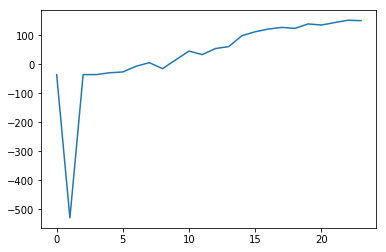

In [83]:
feature_value = np.sum(L, axis=1)
plt.plot(feature_value)
plt.show()

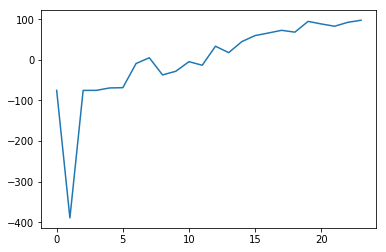

In [43]:
feature_value = np.sum(L, axis=1)
plt.plot(feature_value)
plt.show()

rpca_example

In [25]:
from r_pca import *

# generate low rank synthetic data
N = 100
num_groups = 3
num_values_per_group = 40
p_missing = 0.2

Ds = []
for k in range(num_groups):
    d = np.ones((N, num_values_per_group)) * (k + 1) * 10
    Ds.append(d)

D = np.hstack(Ds)

# decimate 20% of data 
n1, n2 = D.shape
S = np.random.rand(n1, n2)
D[S < 0.2] = 0

# use R_pca to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = R_pca(D)
L, S = rpca.fit(max_iter=10000, iter_print=100)

# visually inspect results (requires matplotlib)
rpca.plot_fit()
plt.show()

100 120
